## Classifier Comparison on RGB Pixel data 

(800L, 3L) (800L,)


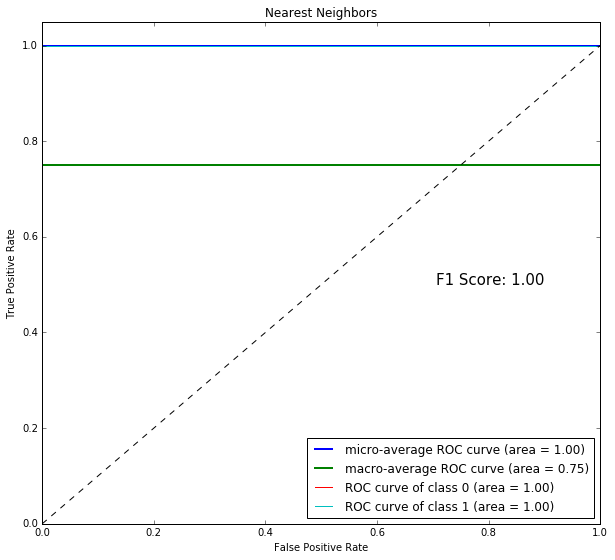

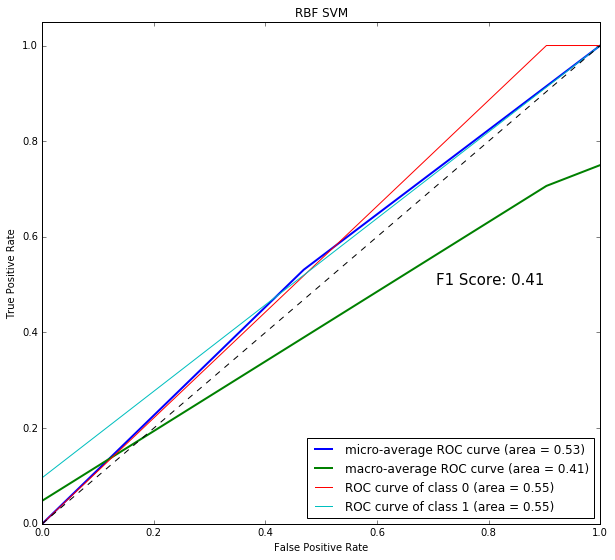

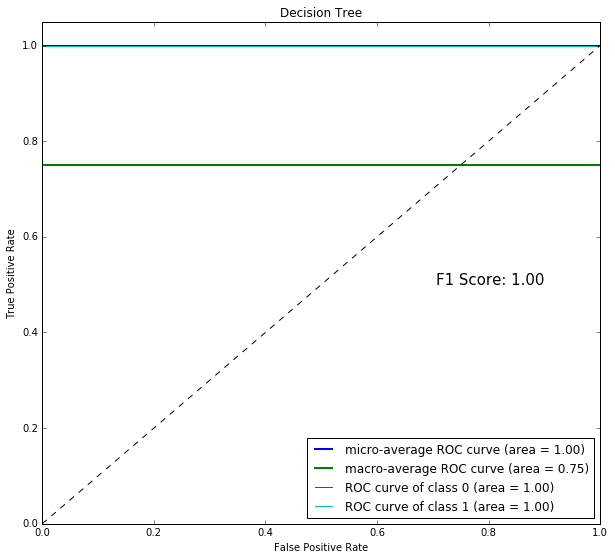

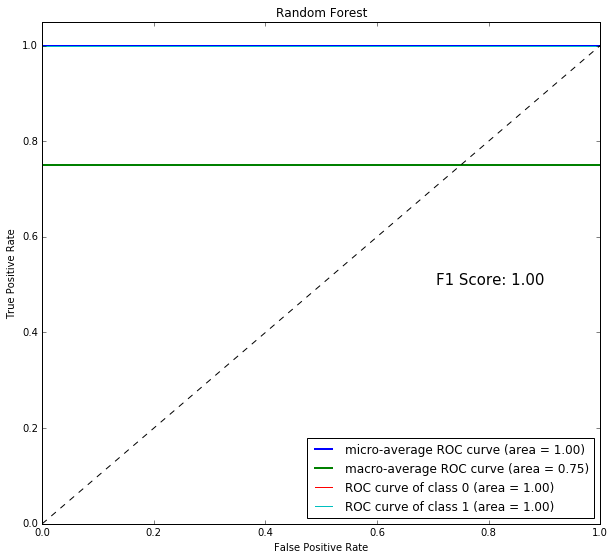

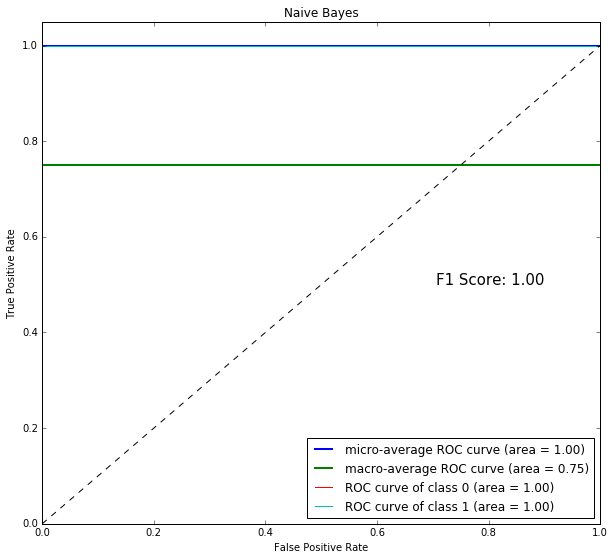

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc,roc_auc_score,f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm
from scipy import interp

# %matplotlib inline

f = open("rgb_800.csv") # Insert name of csv file here (Single sheet)
data =  np.loadtxt(fname = f, delimiter = ',',dtype='double')

X = data[:, :data.shape[1]-1] 
Y = data[:,data.shape[1]-1]
# Replacing 1 & 2 with 0 & 1
Y[Y==1]=0
Y[Y==2]=1

print X.shape, Y.shape

# Normalizing Dataset here

"""mean = X.mean(axis=0)
print mean
std = X.std(axis=0)
print std
X = (X - mean) / std"""

#### Changing Output Shape

Y=Y.astype(int)
n_values = np.max(Y) + 1
Y= np.eye(n_values)[Y]

Y=Y.astype(int)
n_classes = Y.shape[1]

# Uncomment to Use PCA for Analysis 
from sklearn.decomposition import PCA
# X= PCA(n_components=3).fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2)

### Using all Principal Components for Classifier Comparison

names = ["Nearest Neighbors", "RBF SVM", "Decision Tree",
         "Random Forest", "Naive Bayes"]
classifiers = [
    OneVsRestClassifier(KNeighborsClassifier(3)),
    OneVsRestClassifier(SVC(gamma=2, C=1)),
    OneVsRestClassifier(DecisionTreeClassifier(max_depth=5)),
    OneVsRestClassifier(RandomForestClassifier(max_depth=5, n_estimators=10, max_features=data.shape[1]-1)),
    OneVsRestClassifier(GaussianNB())]

for name, clf in zip(names, classifiers):
    clf.fit(X_train,y_train)
    y_score=clf.predict(X_test)
    # print 'y_score: ',y_score
    # print 'y_test: ',y_test
    score=f1_score(y_test,y_score,average='weighted')
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i],tpr[i])
        
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])     
    # First aggregate all false positive rates
    
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
        mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    # Plot all ROC curves
    plt.figure(figsize=(10, 9))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             linewidth=2)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             linewidth=2)
    plt.text(0.9,0.5, ('F1 Score: %.2f' % score).lstrip('0'),
            size=15, horizontalalignment='right')

    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                       ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(name)
    plt.legend(loc="lower right")
    plt.show()